# README

This takes the data generated from gen_npWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method

# Libraries

In [53]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

In [54]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'npWindow_Data'
exp_date = '30Oct23'

spacing = 0.05          #how far did the windows spread around center --> 2*spacing
center_range = 0.1     #how far did we allow the spacing to go
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

c:\co\NIA\


In [55]:
with open(f'{cwd_full}\{base_file}\Espresso_Method\{exp_file}\hprParameter_{method}_sp_{spacing}_rng_{center_range}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SNR_value = dict["SNR_value"]
    rad_diff = dict['rad_diff']
    center_range = dict['center_range']
    center_diff_array = dict['center_diff_array']
    num_centers = dict['num_centers']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

In [56]:
def to_readable(file):
    df = pd.read_pickle(file)
    ALL_CENTER = np.stack(df["Center"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER, ALL_TI, ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [61]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(center_diff_array),3))
    var_ordered = np.zeros((len(center_diff_array),3))
    bias_ordered = np.zeros((len(center_diff_array),3))
    AIC_ordered = np.zeros((len(center_diff_array), 12))

    SNR_ordered = np.zeros((len(center_diff_array)))
    TI_ordered = np.zeros((len(center_diff_array), 12))

    data_name = f"{cwd_full}\{base_file}\Espresso_Method\{exp_file}\{'n'}pWindow_{method}_sp_{spacing}_rng_{center_range}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    Centers, TI_DATA, SNRs, MSE, VAR, BIAS, AIC, pEst_AIC, pEst_cf = to_readable(data_name)

    for index in range(len(Centers)):

        temp_center = Centers[index]

        center_index = np.where(temp_center==center_diff_array)[0][0]

        AIC_ordered[center_index,:] = AIC[index, :]/var_reps
        MSE_ordered[center_index,:] = MSE[index,:,p_oi]
        var_ordered[center_index,:] = VAR[index,:,p_oi]
        bias_ordered[center_index,:] = BIAS[index,:,p_oi]
        SNR_ordered[center_index] = SNRs[index]
        TI_ordered[center_index,:] = TI_DATA[index,:]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered, SNR_ordered, TI_ordered

In [62]:
MSE, var, bias, AIC, SNRs, TI_DATAs = prepare_data(param_oi)

Retrieving data for c:\co\NIA\\Stabilization\Espresso_Method\npWindow_Data\npWindow_AIC_sp_0.05_rng_0.1_30Oct23.pkl


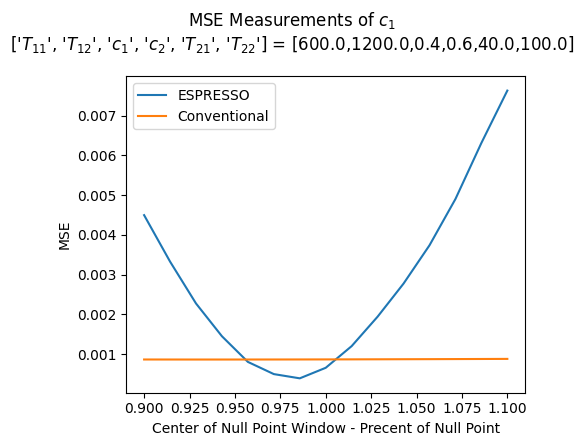

In [63]:
ordering = ["ESPRESSO", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"MSE Measurements of {ParamTitle_6p[param_oi]}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
for i in range(2):
    plt.plot(center_diff_array, MSE[:,i], label = ordering[i])

plt.xlabel("Center of Null Point Window - Precent of Null Point")
plt.ylabel("MSE")
plt.legend()


Text(0.5, 0, 'Center of Null Point Window - Precent of Null Point')

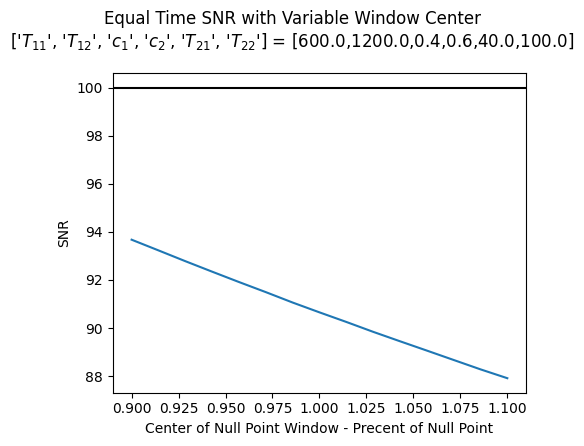

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"Equal Time SNR with Variable Window Center\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
plt.plot(center_diff_array, SNRs, label = "Equal Time")
plt.axhline(y = 100, color = 'k', label = "Standard SNR")
plt.ylabel("SNR")
plt.xlabel("Center of Null Point Window - Precent of Null Point")

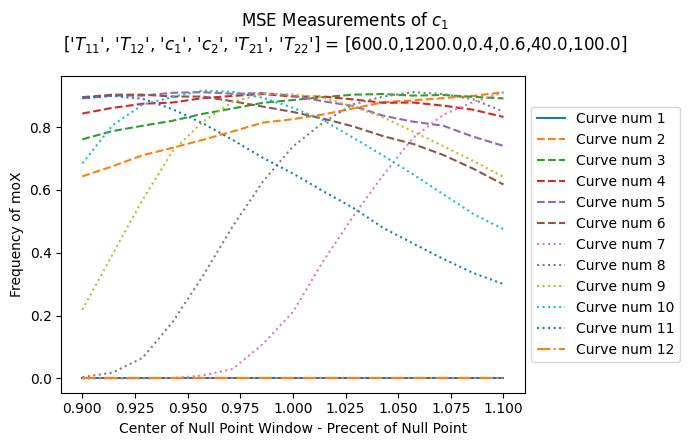

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(7,4.5), tight_layout=True)
fig.suptitle(f"MSE Measurements of {ParamTitle_6p[param_oi]}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
for i in range(AIC.shape[1]):
    if i == 0 :
        plt.plot(center_diff_array, AIC[:,i], label = f'Curve num {i+1}', ls = '-')
    elif i < 5+1 :
        plt.plot(center_diff_array, AIC[:,i], label = f'Curve num {i+1}', ls = '--')
    elif i < 2*5+1 :
        plt.plot(center_diff_array, AIC[:,i], label = f'Curve num {i+1}', ls = ':')
    else:
        plt.plot(center_diff_array, AIC[:,i], label = f'Curve num {i+1}', ls = '-.')

plt.xlabel("Center of Null Point Window - Precent of Null Point")
plt.ylabel("Frequency of moX")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
